> @ChatGPT
> 
> 在使用深度学习进行图像分类时，将图像按大类分类再按小类分类可能会比直接按所有小类分类更容易达到更高的分类精度。
> 
> 这是因为，将图像按大类分类后，模型可以先在较大的类别范围内进行分类，然后再缩小范围，进行更精细的分类。这可以帮助模型在较小的类别范围内更好地学习特征，从而提高分类精度。
> 
> 例如，如果要对动物图像进行分类，可以先将图像分为“哺乳动物”、“鸟类”、“爬行动物”等大类，然后再将每个大类的图像分为更小的类别（例如“狗”、“猫”、“老鹰”等）。这可能会比直接将所有图像分为“狗”、“猫”、“老鹰”等类别更容易达到更高的分类精度。
> 
> 但是，这也可能会增加训练时间和模型的复杂度。因此，在实际应用中，应根据需要选择适当的方法。

# 1. 数据与预处理

In [16]:
'''
from models.AlexNet import alexnet
from models.VggNet import vgg11
from models.VggNet import vgg13
from models.VggNet import vgg16
from models.VggNet import vgg19
from models.GoogleNet_v1 import googlenet
'''
from models.DenseNet import densenet121

import matplotlib.pyplot as plt
import json
import os
import sys
import torch
import torch.nn as nn
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms

In [17]:
data_path = '/root/data/Chest_X-ray2-2_Enhanced/'
# data_path = '/root/data/imagenet-mini/'
assert os.path.exists(data_path), "{} path does not exist.".format(data_path)

In [18]:
# 设置超参数
num_epochs = 20
batch_size = 32
learning_rate = 0.001

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
num_workers = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # 用于加载数据集的进程数量
print('Using {} dataloader workers every process'.format(num_workers))

cuda
Using 8 dataloader workers every process


In [20]:
data_transform = {
    'train': transforms.Compose([
                                # 已经预处理好了
                                # transforms.Resize(224),
                                # transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    'val': transforms.Compose([
                                # 已经预处理好了
                                # transforms.Resize(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    }

In [21]:
# 加载训练集
train_dataset = torchvision.datasets.ImageFolder(root = os.path.join(data_path, 'train'), transform=data_transform['train'])
# 加载验证集
val_dataset = torchvision.datasets.ImageFolder(root = os.path.join(data_path, 'val'), transform=data_transform['val'])

train_num = len(train_dataset)
val_num = len(val_dataset)

In [22]:
# 配置Data loader，一次训练载入一个batch_size的数据
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
print("using {} images for training, {} images for validation.".format(train_num, val_num))

using 3875 images for training, 13 images for validation.


In [23]:
# 使用class_to_idx给类别一个index，作为训练时的标签： {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
flower_list = train_dataset.class_to_idx
# print(flower_list)

# 创建一个字典，存储index和类别的对应关系，在模型推理阶段会用到。
cla_dict = dict((val, key) for key, val in flower_list.items())
# print(cla_dict)

# 将字典写成一个json文件
json_str = json.dumps(cla_dict, indent=4)
with open( os.path.join(data_path, 'class_indices.json') , 'w') as json_file:
    json_file.write(json_str)
print(len(flower_list), json_str)


2 {
    "0": "bacteria",
    "1": "virus"
}


# 2. 模型与训练

In [9]:
'''
model_alexnet = alexnet(num_classes=2).to(device)
model_vgg11 = vgg11(num_classes=2)#.to(device)
model_vgg13 = vgg13(num_classes=2)#.to(device)
model_vgg16 = vgg16(num_classes=2)#.to(device)
model_vgg19 = vgg19(num_classes=2)#.to(device)
'''

'\nmodel_alexnet = alexnet(num_classes=2).to(device)\nmodel_vgg11 = vgg11(num_classes=2)#.to(device)\nmodel_vgg13 = vgg13(num_classes=2)#.to(device)\nmodel_vgg16 = vgg16(num_classes=2)#.to(device)\nmodel_vgg19 = vgg19(num_classes=2)#.to(device)\n'

In [28]:
def train_model(model):
    # model = model_class(num_classes=2).to(device)
    model = model.to(device)
    # 损失函数与优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9, weight_decay = 0.0005)

    model.train()
    

    # 开始迭代
    for epoch in range(num_epochs):
        # 显示进度条
        train_bar = tqdm(train_loader, file = sys.stdout, ncols = 100)

        # 批处理
        for i, (images, labels) in enumerate(train_bar):

            images = images.to(device); labels = labels.to(device)

            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 反向优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            Loss.append(loss.item())

            train_bar.desc = "train epoch[{}/{}] loss:{:.6f}".format(epoch + 1, num_epochs, loss)
    
    plt.plot(Loss)
    print(model, Loss)
    
    '''
    # 清除模型和缓存，慎用！！！
    del model
    # torch.cuda.empty_cache()
    '''

In [10]:
'''
model = vgg19(num_classes=1000)
model.load_state_dict(torch.load('./results/weights/Chest_X-ray2-2_Enhanced/VggNet19.pth',  map_location=torch.device("cpu")))
'''
import torchvision.models as models
# 加载预训练的 AlexNet 模型
# model = models.alexnet(pretrained=True)
# model = models.vgg19(pretrained=True)
# model = models.resnet18(pretrained=True)
# model = models.resnet34(pretrained=True)
# model = models.googlenet(pretrained=True)
# model = models.densenet121(pretrained=True)
model = densenet121(num_classes=1000)
model.load_state_dict(torch.load('./results/weights/Chest_X-ray2-2_Enhanced/DenseNet.pth',  map_location=torch.device("cpu")))


<All keys matched successfully>

In [29]:
Loss = []
train_model(model)

train epoch[1/20] loss:0.000795:  23%|██████▋                      | 28/122 [00:16<00:56,  1.66it/s]


KeyboardInterrupt: 

In [30]:
print('finished')

finished


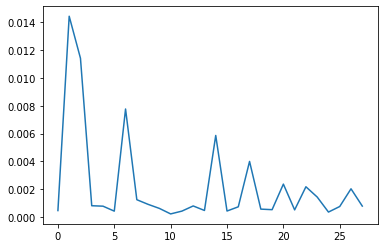

In [31]:
plt.plot(Loss)

In [32]:
sum(Loss[2000:2300])/300

0.0

# 3. 模型评估

In [33]:
save_path = os.path.abspath(os.path.join(os.getcwd(), './results/weights/Chest_X-ray2-2_Enhanced/'))   #os.getcwd()返回当前目录
if not os.path.exists(save_path):    
    os.mkdir(save_path)         #与Linux下相同语法

In [34]:
val_accurate = 0.0
def val_model(model, name):
    model.eval()
    best_acc = 0.0

    with torch.no_grad():
        correct = 0; total = 0
        val_bar = tqdm(train_loader, file=sys.stdout, ncols=100) 
        for i, (images, labels) in enumerate(val_bar):
            images = images.to(device); labels = labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            val_accurate = correct / total

            # 判断当前验证集的准确率是否是最大的，如果是，则更新之前保存的权重
            if val_accurate > best_acc:
                best_acc = val_accurate
                torch.save(model.state_dict(), os.path.join(save_path, name+'.pth') )
            if (i + 1) % 10 == 0:
                print('\n[epoch %d] val_accuracy: %.3f' %  (i + 1, val_accurate))
   

In [35]:
val_model(model, 'DenseNet121')

  7%|████▏                                                          | 8/122 [00:11<01:14,  1.53it/s]
[epoch 10] val_accuracy: 1.000
 16%|█████████▋                                                    | 19/122 [00:12<00:11,  9.15it/s]
[epoch 20] val_accuracy: 1.000
 23%|██████████████▏                                               | 28/122 [00:13<00:06, 15.48it/s]
[epoch 30] val_accuracy: 1.000
 31%|███████████████████▎                                          | 38/122 [00:16<00:14,  5.79it/s]
[epoch 40] val_accuracy: 1.000
 40%|████████████████████████▉                                     | 49/122 [00:17<00:11,  6.56it/s]
[epoch 50] val_accuracy: 1.000
 48%|█████████████████████████████▍                                | 58/122 [00:18<00:04, 14.72it/s]
[epoch 60] val_accuracy: 1.000
 56%|██████████████████████████████████▌                           | 68/122 [00:21<00:08,  6.52it/s]
[epoch 70] val_accuracy: 1.000
 64%|███████████████████████████████████████▋                      | 78/122 

In [36]:
val_accurate

0.0